In [16]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.utils import set_random_seed
from keras.utils import set_random_seed
import pandas as pd
from tensorflow.keras.utils import plot_model

In [18]:
# Установка начального состояния для воспроизводимости результатов
set_random_seed(21)

# Загрузка данных CIFAR-10
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

print(f"Размер обучающего набора: {len(train_images)}, Размер начального тестового набора: {len(test_images)}")

# Разделение начального тестового набора на валидационный и окончательный тестовый наборы
validation_images, final_test_images, validation_labels, final_test_labels = train_test_split(
    test_images, test_labels, test_size=0.2, random_state=21)

# Нормализация данных
train_images_normalized = train_images / 255.0
final_test_images_normalized = final_test_images / 255.0
validation_images_normalized = validation_images / 255.0

# Вывод размеров наборов данных после предобработки
print(f"Размер обучающего набора: {len(train_images_normalized)}")
print(f"Размер валидационного набора: {len(validation_images_normalized)}")
print(f"Размер окончательного тестового набора: {len(final_test_images_normalized)}")

Размер обучающего набора: 50000, Размер начального тестового набора: 10000
Размер обучающего набора: 50000
Размер валидационного набора: 8000
Размер окончательного тестового набора: 2000


In [10]:
def load_images_and_split_sections(images):
    first_images, second_images, section_labels = [], [], []
    
    # Координаты для разделения исходных изображений на четыре секции
    section_coordinates = [
        [[0, 32], [0, 32]], 
        [[0, 32], [32, 64]], 
        [[32, 64], [0, 32]], 
        [[32, 64], [32, 64]]
    ]
    
    # Перебираем каждое изображение в переданном списке
    for img in images:
        # Увеличиваем размер исходного изображения
        img_resized = tf.image.resize(img, [32*2, 32*2])
        
        # Случайно выбираем две разные секции из четырех
        sections = [0, 1, 2, 3]
        first_section_index = np.random.choice(sections)
        sections.remove(first_section_index)
        second_section_index = np.random.choice(sections)
        
        # Вырезаем выбранные секции из изображения
        first_section = img_resized[
            section_coordinates[first_section_index][0][0]:section_coordinates[first_section_index][0][1], 
            section_coordinates[first_section_index][1][0]:section_coordinates[first_section_index][1][1]
        ]
        
        second_section = img_resized[
            section_coordinates[second_section_index][0][0]:section_coordinates[second_section_index][0][1], 
            section_coordinates[second_section_index][1][0]:section_coordinates[second_section_index][1][1]
        ]

        # Добавляем вырезанные секции и метку второй секции в соответствующие списки
        first_images.append(first_section)
        second_images.append(second_section)
        section_labels.append(second_section_index)

    first_images_array = np.asarray(first_images)
    second_images_array = np.asarray(second_images)
    section_labels_categorical = keras.utils.to_categorical(section_labels, num_classes=4)

    return first_images_array, second_images_array, section_labels_categorical

# Применяем функцию к обучающему и валидационному наборам данных
train_first, train_second, train_labels = load_images_and_split_sections(X_train)
valid_first, valid_second, valid_labels = load_images_and_split_sections(X_valid)

# Выводим размерности полученных массивов данных
print(f"Размер первого набора обучающих секций: {train_first.shape}")
print(f"Размер второго набора обучающих секций: {train_second.shape}")
print(f"Размер меток обучающих секций: {train_labels.shape}")

print(f"Размер первого набора валидационных секций: {valid_first.shape}")
print(f"Размер второго набора валидационных секций: {valid_second.shape}")
print(f"Размер меток валидационных секций: {valid_labels.shape}")

Размер первого набора обучающих секций: (50000, 32, 32, 3)
Размер второго набора обучающих секций: (50000, 32, 32, 3)
Размер меток обучающих секций: (50000, 4)
Размер первого набора валидационных секций: (8000, 32, 32, 3)
Размер второго набора валидационных секций: (8000, 32, 32, 3)
Размер меток валидационных секций: (8000, 4)


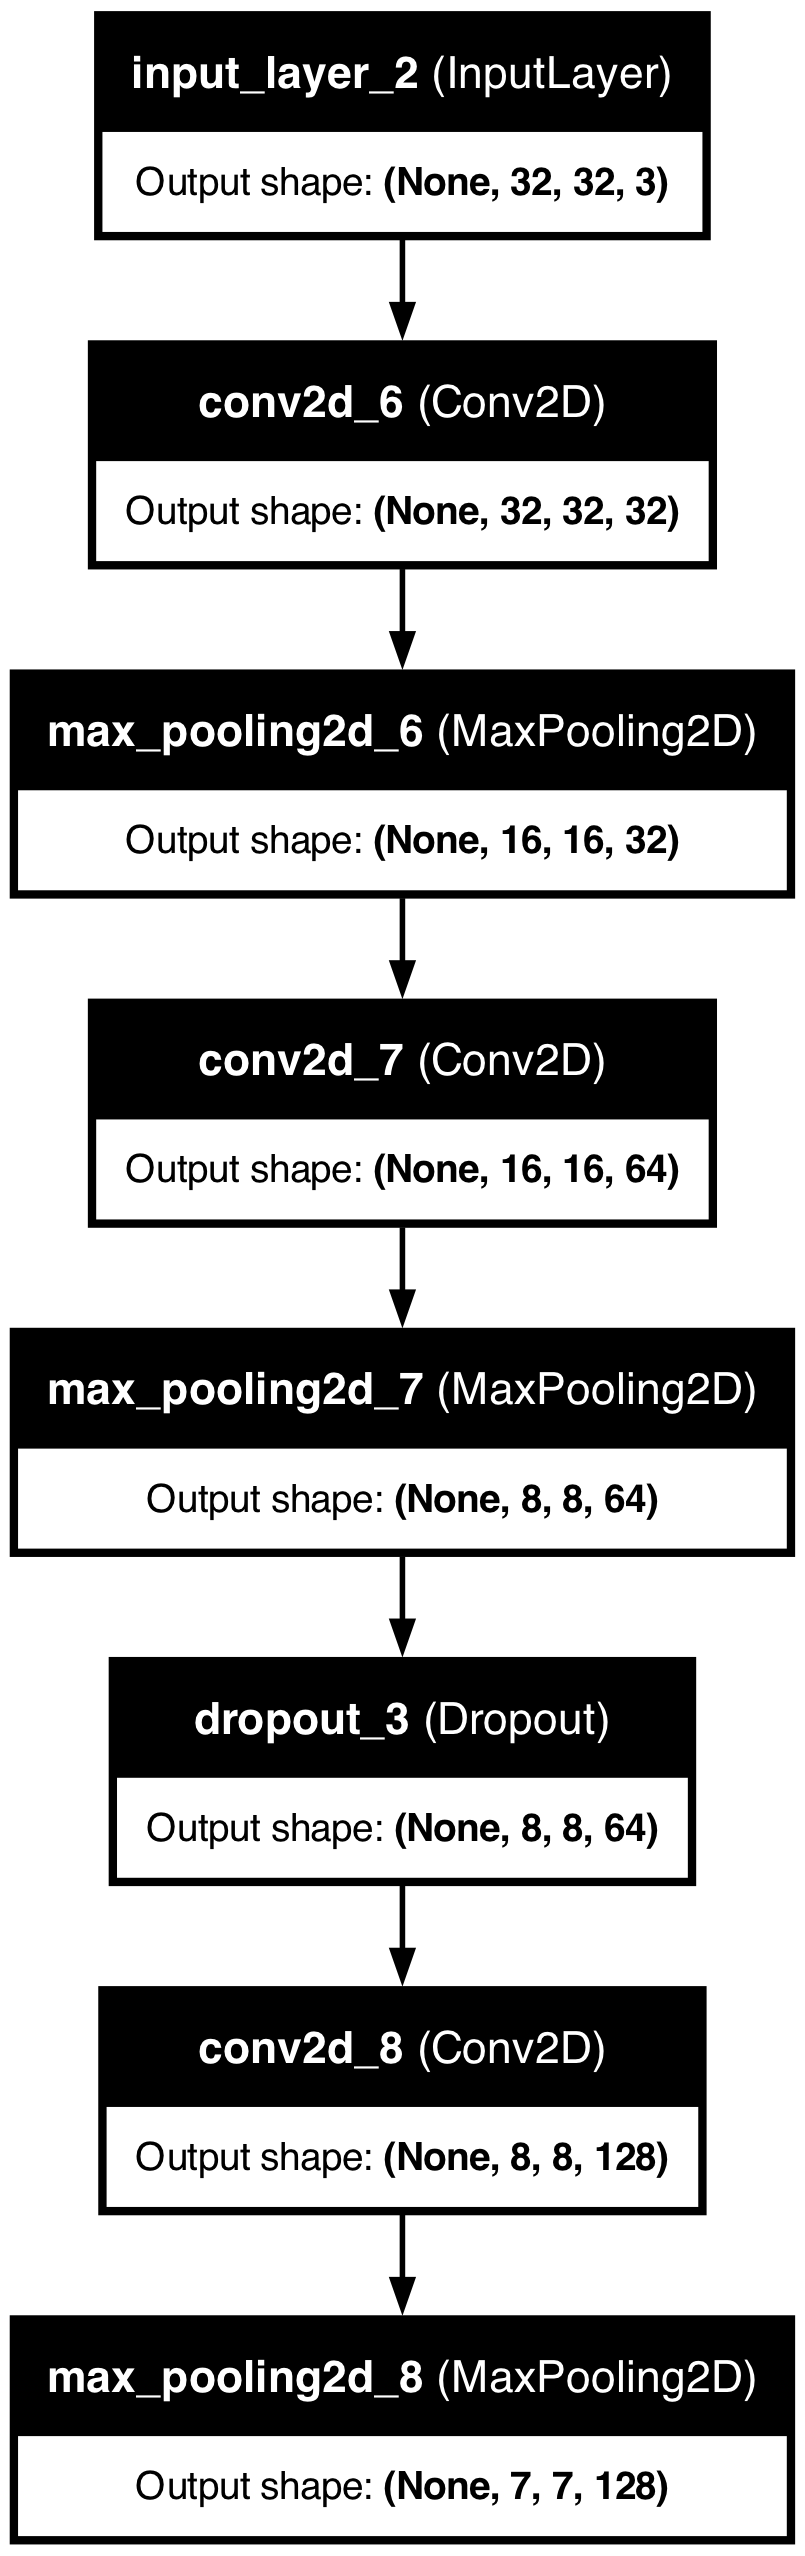

In [21]:
inputs = keras.Input(shape=(32, 32, 3))
x = keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
x = keras.layers.MaxPooling2D((2, 2), strides=2)(x)
x = keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = keras.layers.MaxPooling2D((2, 2), strides=2)(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Conv2D(128, (2, 2), padding='same', activation='relu')(x)
outputs = keras.layers.MaxPooling2D((2, 2), strides=1)(x)

backbone = keras.models.Model(inputs=inputs, outputs=outputs)

# Визуализация архитектуры модели 
plot_model(backbone, to_file='model.png', show_shapes=True, show_layer_names=True)

In [22]:
backbone.weights

[<KerasVariable shape=(3, 3, 3, 32), dtype=float32, path=conv2d_6/kernel>,
 <KerasVariable shape=(32,), dtype=float32, path=conv2d_6/bias>,
 <KerasVariable shape=(3, 3, 32, 64), dtype=float32, path=conv2d_7/kernel>,
 <KerasVariable shape=(64,), dtype=float32, path=conv2d_7/bias>,
 <KerasVariable shape=(2, 2, 64, 128), dtype=float32, path=conv2d_8/kernel>,
 <KerasVariable shape=(128,), dtype=float32, path=conv2d_8/bias>]

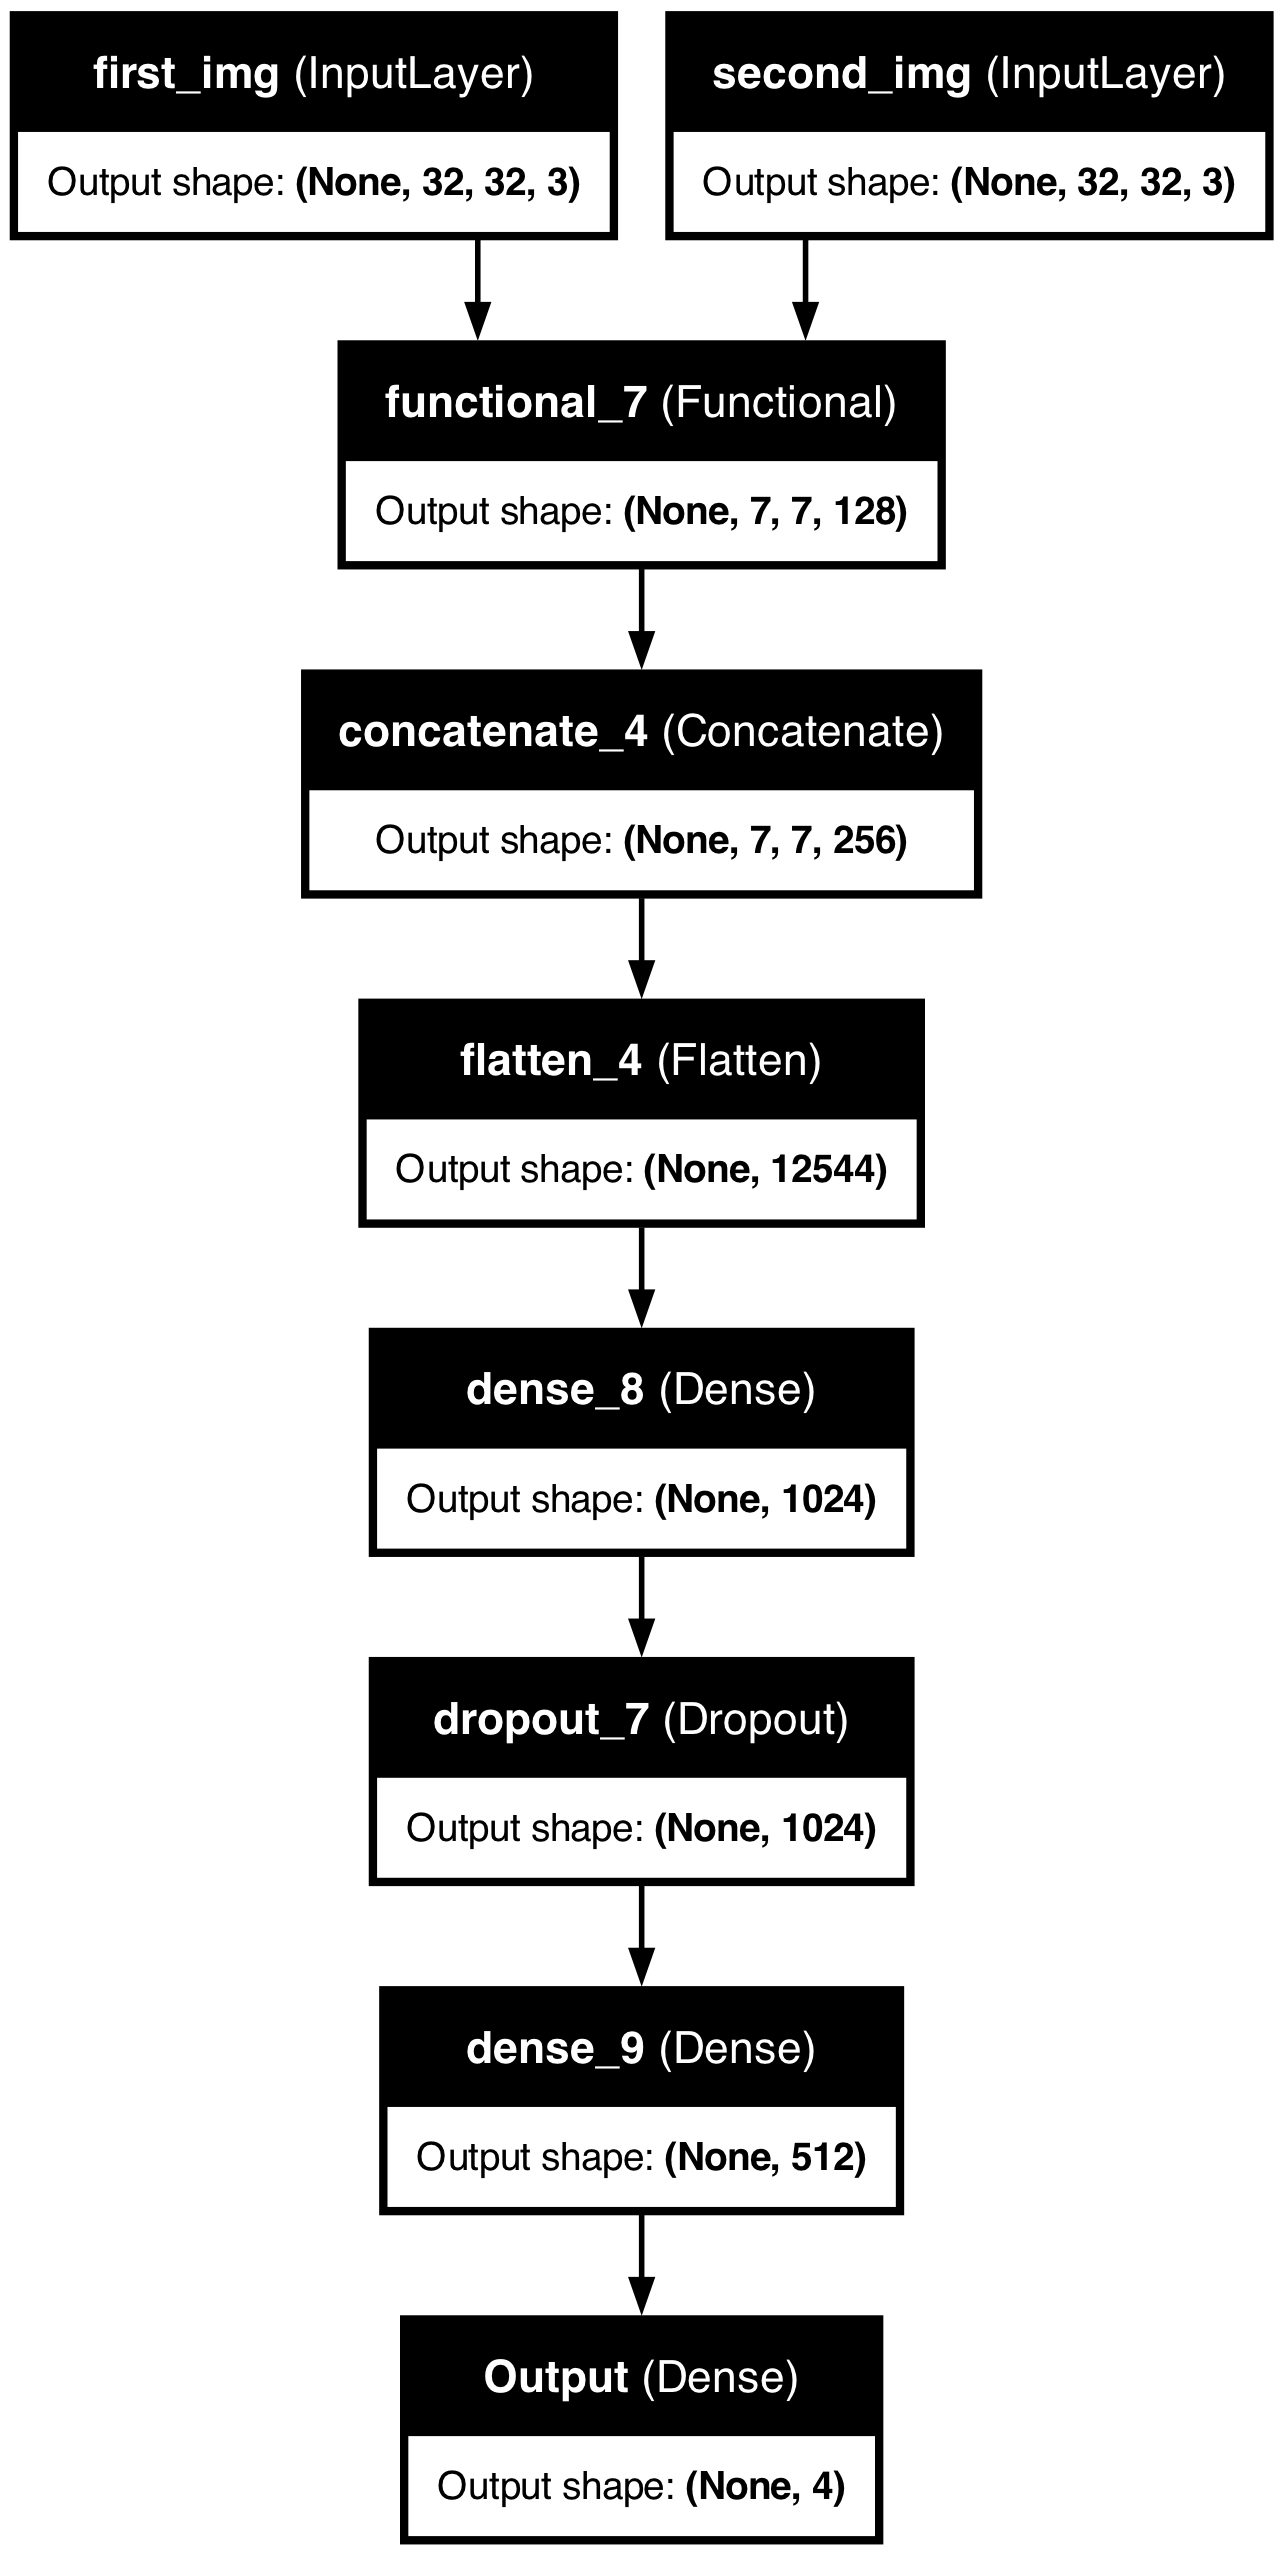

In [26]:
from tensorflow.keras.utils import plot_model
#SSL model
inputs1 = keras.Input(shape = (32,32,3), name='first_img')
inputs2 = keras.Input(shape = (32,32,3), name='second_img')
backbone1 = backbone(inputs1)
backbone2 = backbone(inputs2)
inputs = keras.layers.Concatenate()([backbone1, backbone2])
x = keras.layers.Flatten()(inputs)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(512, activation='relu')(x)
outputs = keras.layers.Dense(4, activation='softmax', name='Output')(x)

ssl_model = keras.models.Model(inputs = [inputs1, inputs2], outputs = outputs)
ssl_model.summary

plot_model(ssl_model, to_file='ssl_model.png', show_shapes=True, show_layer_names=True)

In [27]:
# Компиляция модели
ssl_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    loss="categorical_crossentropy",
    metrics=[
        keras.metrics.F1Score(average='weighted'), 
        keras.metrics.Precision(), 
        keras.metrics.Recall()
    ]
)

# Подготовка данных для обучения и валидации
train_data = {'first_img': train_first, 'second_img': train_second}
valid_data = {'first_img': valid_first, 'second_img': valid_second}

# Обучение модели
history = ssl_model.fit(
    train_data, 
    train_outputs,
    validation_data=(valid_data, valid_outputs),
    batch_size=256, 
    epochs=20
)

Epoch 1/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 154s 768ms/step - f1_score: 0.3734 - loss: 1.2882 - precision_1: 0.5191 - recall_1: 0.1076 - val_f1_score: 0.6629 - val_loss: 0.8272 - val_precision_1: 0.7764 - val_recall_1: 0.5520
Epoch 2/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 131s 666ms/step - f1_score: 0.6742 - loss: 0.8137 - precision_1: 0.7525 - recall_1: 0.5735 - val_f1_score: 0.7409 - val_loss: 0.6710 - val_precision_1: 0.8048 - val_recall_1: 0.6555
Epoch 3/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 130s 664ms/step - f1_score: 0.7288 - loss: 0.6872 - precision_1: 0.7913 - recall_1: 0.6571 - val_f1_score: 0.7752 - val_loss: 0.5729 - val_precision_1: 0.8304 - val_recall_1: 0.7150
Epoch 4/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 126s 643ms/step - f1_score: 0.7643 - loss: 0.6040 - precision_1: 0.8136 - recall_1: 0.7106 - val_f1_score: 0.8041 - val_loss: 0.5037 - val_precision_1: 0.8434 - val_recall_1: 0.7675
Epoch 5/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 134s 682ms/step - f1_score: 0.7927 - loss: 0.5337 - precision_1: 0.8337 

In [5]:
import os

weights_dir = 'Weights'

if not os.path.exists(weights_dir):
    os.makedirs(weights_dir)

backbone.save_weights(os.path.join(weights_dir, 'backbone.weights.h5'))

print("Weights structure of the backbone model:")
for weight in backbone.weights:
    print(weight)

NameError: name 'backbone' is not defined

In [6]:
#Подготовим данные для обучения
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)
y_valid = keras.utils.to_categorical(y_valid, 10)

X_dataset_train = tf.data.Dataset.from_tensor_slices(X_train)
y_dataset_train = tf.data.Dataset.from_tensor_slices(y_train)

dataset_train = tf.data.Dataset.zip((X_dataset_train, y_dataset_train))

X_dataset_valid = tf.data.Dataset.from_tensor_slices(X_valid)
y_dataset_valid = tf.data.Dataset.from_tensor_slices(y_valid)

dataset_valid = tf.data.Dataset.zip((X_dataset_valid, y_dataset_valid))

dataset_train = dataset_train.shuffle(500).batch(256).prefetch(tf.data.experimental.AUTOTUNE)
dataset_valid = dataset_valid.shuffle(500).batch(256).prefetch(tf.data.experimental.AUTOTUNE)

X_dataset_test = tf.data.Dataset.from_tensor_slices(X_test)
y_dataset_test = tf.data.Dataset.from_tensor_slices(y_test)

dataset_test = tf.data.Dataset.zip((X_dataset_test, y_dataset_test))
dataset_test = dataset_test.shuffle(500).batch(256).prefetch(tf.data.experimental.AUTOTUNE)



NameError: name 'y_train' is not defined

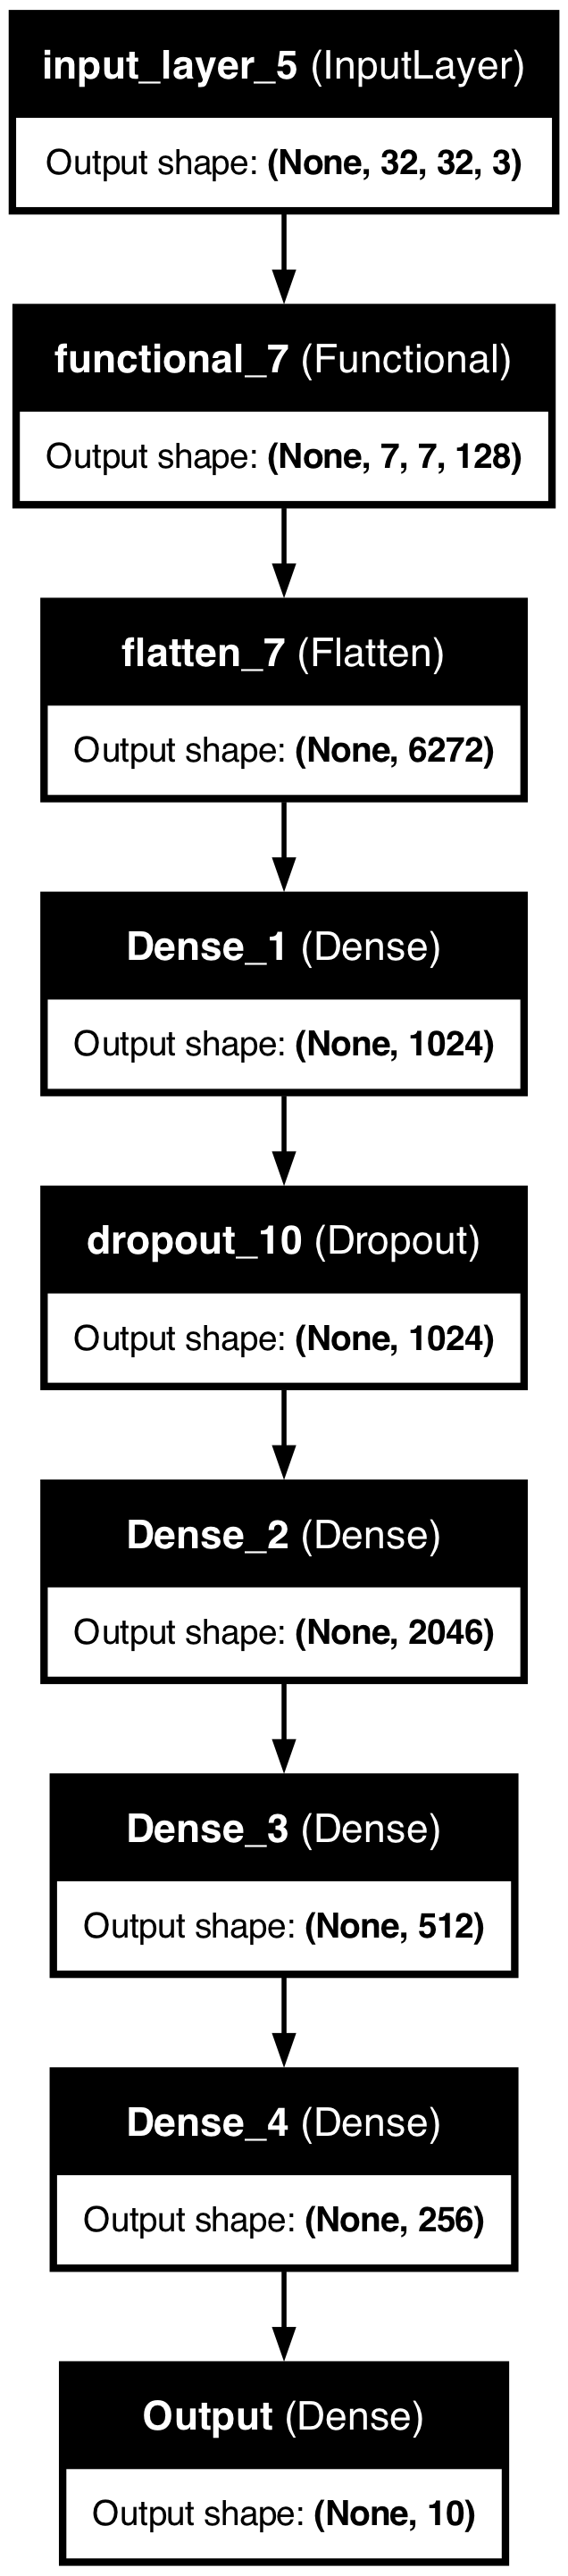

In [55]:
# Expirement 1 обучение на всем датасете

backbone.load_weights('Weights/backbone.weights.h5')
backbone.weights

inputs = keras.Input(shape = (32,32,3))
x=backbone(inputs)
x=keras.layers.Flatten()(x)
x=keras.layers.Dense(1024, activation="relu", name='Dense_1')(x)
x=keras.layers.Dropout(0.3)(x)
x=keras.layers.Dense(2046, activation='relu', name='Dense_2')(x)
x=keras.layers.Dense(512, activation='relu', name='Dense_3')(x)
x=keras.layers.Dense(256, activation='relu', name='Dense_4')(x)
output=keras.layers.Dense(10, activation='softmax', name='Output')(x)

model_1 = keras.models.Model(inputs = inputs, outputs = output)

plot_model(model_1, to_file='model_1.png', show_shapes=True, show_layer_names=True)

In [4]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.utils import set_random_seed
from keras.utils import set_random_seed
import pandas as pd
from tensorflow.keras.utils import plot_model

# Компиляция модели
learning_rate = 0.0005
optimizer = keras.optimizers.Adam(learning_rate)
metrics=[
    keras.metrics.F1Score(average='weighted', name='f1_score'),
    keras.metrics.Precision(name='precision_1'),
    keras.metrics.Recall(name='recall_1')
]

model_1.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=metrics)

# Настройка колбэков
patience_val = 3
factor_val = 0.5
min_lr_val = 1e-6
learn_rate_red = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", patience=patience_val, factor=factor_val, min_lr=min_lr_val)

early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=6)
tensorboard = keras.callbacks.TensorBoard(log_dir="logs/Exp_1")

# Обучение модели
epochs_num = 20
history_1 = model_1.fit(
    dataset_train,
    validation_data=dataset_valid,
    epochs=epochs_num,
    callbacks=[learn_rate_red, early_stop, tensorboard]
)

# Оценка модели
eval_hist_1 = model_1.evaluate(dataset_test)

# Вывод результатов
print(f"Eval_loss = {eval_hist_1[0]:.4f} \nEval_f1 = {eval_hist_1[1]:.4f} \nEval_precision = {eval_hist_1[2]:.4f} \nEval_recall = {eval_hist_1[3]:.4f}")

NameError: name 'model_1' is not defined

In [3]:
#График изменения функции потерь
history_df = pd.DataFrame(history_1.history)
history_df.loc[:, ['loss', 'val_loss']].plot()

NameError: name 'pd' is not defined

In [ ]:
history_df.loc[:, ['recall_1', 'val_recall_1']].plot()

In [ ]:
history_df.loc[:, ['precision_1', 'val_precision_1']].plot()

In [ ]:
history_df.loc[:, ['f1_score', 'val_f1_score']].plot()

In [ ]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(history_df['loss'], color='blue')
axs[0, 0].plot(history_df['val_loss'], color='orange')
axs[0, 0].set_title('loss graphs')
axs[0, 0].grid()
axs[0, 1].plot(history_df['precision_1'], color='blue')
axs[0, 1].plot(history_df['val_precision_1'], color='orange')
axs[0, 1].set_title('precision graphs')
axs[0, 1].grid()
axs[1, 0].plot(history_df['recall_1'], color='blue')
axs[1, 0].plot(history_df['val_recall_1'], color='orange')
axs[1, 0].set_title('recall graphs')
axs[1, 0].grid()
axs[1, 1].plot(history_df['f1_score'], color='blue')
axs[1, 1].plot(history_df['val_f1_score'], color='orange')
axs[1, 1].set_title('f1_score graphs')
axs[1, 1].grid()
fig.tight_layout()
plt.show()

In [ ]:
preds = exp_1_model.predict(X_test)
preds = np.argmax(preds, axis=1)
y_test_idx = np.argmax(y_test, axis=1)
print(classification_report(y_test_idx, preds))

In [ ]:
# Exp 2 Проведем эксперимент с предобученным бэкбоном и 50% датасетом

dataset_train_2 = dataset_train.shard(num_shards=2, index=0)
len(dataset_train_2)*256
backbone.load_weights('../Weights/backbone')
backbone.weights
#Зададим наш классификатор
inputs = keras.Input(shape = (32,32,3))
x=backbone(inputs)
x=keras.layers.Flatten()(x)
x=keras.layers.Dense(1024, activation="relu", name='Dense_1')(x)
x=keras.layers.Dropout(0.3)(x)
x=keras.layers.Dense(2046, activation='relu', name='Dense_2')(x)
x=keras.layers.Dense(512, activation='relu', name='Dense_3')(x)
x=keras.layers.Dense(256, activation='relu', name='Dense_4')(x)
output=keras.layers.Dense(10, activation='softmax', name='Output')(x)

exp_2_model = keras.models.Model(inputs = inputs, outputs = output)
exp_2_model.summary()

In [ ]:
exp_2_model.compile(keras.optimizers.legacy.Adam(0.0005), loss="categorical_crossentropy",
              metrics=[keras.metrics.F1Score(average = 'weighted'), 
                       keras.metrics.Precision(name='precision_2'), 
                       keras.metrics.Recall(name='recall_2')])
learn_rate_red=keras.callbacks.ReduceLROnPlateau("val_loss", patience=3, factor = 0.5, min_lr=1e-6)
early_stop = keras.callbacks.EarlyStopping("val_loss", patience=6)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir="../logs/Exp_2")

%%time
history_2 = exp_2_model.fit(dataset_train_2, validation_data=dataset_valid, 
                    epochs=50, callbacks=[learn_rate_red, early_stop, tensorboard])

eval_hist_2 = exp_2_model.evaluate(dataset_test)

print("Eval_loss = {} \nEval_f1 = {} \nEval_precision = {} \nEval_recall = {}".format(eval_hist_2[0], 
                                                                                      eval_hist_2[1], 
                                                                                      eval_hist_2[2],
                                                                                      eval_hist_2[3]))

#График изменения функции потерь
history_df = pd.DataFrame(history_2.history)
history_df.loc[:, ['loss', 'val_loss']].plot()

In [ ]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(history_df['loss'], color='blue')
axs[0, 0].plot(history_df['val_loss'], color='orange')
axs[0, 0].set_title('loss graphs')
axs[0, 0].grid()
axs[0, 1].plot(history_df['precision_2'], color='blue')
axs[0, 1].plot(history_df['val_precision_2'], color='orange')
axs[0, 1].set_title('precision graphs')
axs[0, 1].grid()
axs[1, 0].plot(history_df['recall_2'], color='blue')
axs[1, 0].plot(history_df['val_recall_2'], color='orange')
axs[1, 0].set_title('recall graphs')
axs[1, 0].grid()
axs[1, 1].plot(history_df['f1_score'], color='blue')
axs[1, 1].plot(history_df['val_f1_score'], color='orange')
axs[1, 1].set_title('f1_score graphs')
axs[1, 1].grid()
fig.tight_layout()
plt.show()

In [ ]:
preds = exp_2_model.predict(X_test, verbose=0)
preds = np.argmax(preds, axis=1)
y_test_idx = np.argmax(y_test, axis=1)
print(classification_report(y_test_idx, preds))

In [ ]:
# Exp 3 Проведем эксперимент с предобученным бэкбоном и 10% датасетом

dataset_train_3 = dataset_train.shard(num_shards=10, index=0)

len(dataset_train_3)*256

backbone.load_weights('../Weights/backbone')
backbone.weights

In [ ]:
#Зададим наш классификатор
inputs = keras.Input(shape = (32,32,3))
x=backbone(inputs)
x=keras.layers.Flatten()(x)
x=keras.layers.Dense(1024, activation="relu", name='Dense_1')(x)
x=keras.layers.Dropout(0.3)(x)
x=keras.layers.Dense(2046, activation='relu', name='Dense_2')(x)
x=keras.layers.Dense(512, activation='relu', name='Dense_3')(x)
x=keras.layers.Dense(256, activation='relu', name='Dense_4')(x)
output=keras.layers.Dense(10, activation='softmax', name='Output')(x)

exp_3_model = keras.models.Model(inputs = inputs, outputs = output)
exp_3_model.summary()

In [ ]:
exp_3_model.compile(keras.optimizers.legacy.Adam(0.0005), loss="categorical_crossentropy",
              metrics=[keras.metrics.F1Score(average = 'weighted'), 
                       keras.metrics.Precision(name='precision_3'), 
                       keras.metrics.Recall(name='recall_3')])

learn_rate_red=keras.callbacks.ReduceLROnPlateau("val_loss", patience=3, factor = 0.5, min_lr=1e-6)
early_stop = keras.callbacks.EarlyStopping("val_loss", patience=6)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir="../logs/Exp_3")

%%time
history_3 = exp_3_model.fit(dataset_train_3, validation_data=dataset_valid, 
                    epochs=50, callbacks=[learn_rate_red, early_stop, tensorboard])

eval_hist_3 = exp_3_model.evaluate(dataset_test)

print("Eval_loss = {} \nEval_f1 = {} \nEval_precision = {} \nEval_recall = {}".format(eval_hist_3[0], 
                                                                                      eval_hist_3[1], 
                                                                                      eval_hist_3[2],
                                                                                      eval_hist_3[3]))

In [ ]:
#График изменения функции потерь
history_df = pd.DataFrame(history_3.history)
history_df.loc[:, ['loss', 'val_loss']].plot()

fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(history_df['loss'], color='blue')
axs[0, 0].plot(history_df['val_loss'], color='orange')
axs[0, 0].set_title('loss graphs')
axs[0, 0].grid()
axs[0, 1].plot(history_df['precision_3'], color='blue')
axs[0, 1].plot(history_df['val_precision_3'], color='orange')
axs[0, 1].set_title('precision graphs')
axs[0, 1].grid()
axs[1, 0].plot(history_df['recall_3'], color='blue')
axs[1, 0].plot(history_df['val_recall_3'], color='orange')
axs[1, 0].set_title('recall graphs')
axs[1, 0].grid()
axs[1, 1].plot(history_df['f1_score'], color='blue')
axs[1, 1].plot(history_df['val_f1_score'], color='orange')
axs[1, 1].set_title('f1_score graphs')
axs[1, 1].grid()
fig.tight_layout()
plt.show()

In [ ]:
preds = exp_3_model.predict(X_test, verbose=0)
preds = np.argmax(preds, axis=1)
y_test_idx = np.argmax(y_test, axis=1)
print(classification_report(y_test_idx, preds))

In [ ]:
h, w = (2, 3)
fig, axs = plt.subplots(w, h)
for i in range(w):
    for j in range(h):
        num = np.random.randint(2000)
        pred = exp_2_model.predict(np.expand_dims(X_test[num], axis=0), verbose=0)
        pred = np.argmax(pred)
        y_test_idx = np.argmax(y_test[num])
        axs[i, j].imshow(X_test[num])
        axs[i, j].set_title('Predicted class:'+str(pred)+'  Real class:'+str(y_test_idx))
        axs[i, j].set(xticks=[], yticks=[])